# PV modeling example

In this example we compute the optimal PV parameters for the IV curve based on historical data.

In [46]:
%matplotlib inline

In [47]:
import os, sys

In [48]:
ROOT_PATH = os.getenv("PROJECT_HOME")
sys.path.append(ROOT_PATH)

In [49]:
import numpy as np
import pandas as pd
from smartgrid.pvmodeling.functions import standard_cell_temperature, photo_current, saturationCourant, i_from_v_exp, ivcurve_newton_raphson

## PV module parameters

In [50]:
Ncell = 60
Gstc = 1000 # W/m
Tstc = 25+273.15 # K
Tambnoct = 20
Tnoct = 46 # C
Gnoct = 800 # W/m
Imppnoct = 7.43
Vmppnoct = 28.7
Iscstc = 9.84 # A
Ki = 0.04 / 100 * Iscstc # A/C
Eg = 1.8e-19 # Bandgap do sil�cio cristalino em J (=1.124 eV)
Vocnoct = 36.4

Calepinage utilisé pour tracer les courbes IV

In [51]:
Ns = 1 # Nombre de module(s) en s�rie
Ns0 = Ns * Ncell # Nombre de cellule(s) en s�rie
Nsh = 1 # Nombre de module en parall�le

## Loading data for IV curve

In [54]:
ivcurve = pd.read_excel("{root}/acceptance_tests/data/IVcurve.xlsx".format(root=ROOT_PATH))

Conditions expérimentales lors de la courbe IV

In [8]:
G = 885;
Tamb = 25 + 273.15;

I_exp = ivcurve.I;
V_exp = ivcurve.V;

In [9]:
effectiveIrradiance = G

In [10]:
Tcell = standard_cell_temperature(Tamb,effectiveIrradiance,Tnoct,Tambnoct,Gnoct)

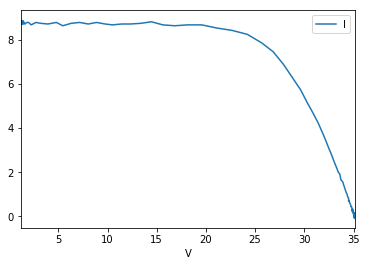

In [11]:
ivcurve.sort_values("V").plot(x="V", y="I")

In [12]:
param_example = dict(a_ref=1.411,
                     R_s=0.512,
                     R_sh_ref=1045,
                     I_L_ref=9.78,
                     I_0_ref=5.65e-8)

In [13]:
def pvopt_objfun(x):
    aref, Rs, Rsh, Iphref, I0ref = x
    Iph = photo_current(Iphref, effectiveIrradiance, Gstc, Ki, Tcell, Tstc)
    I0 = saturationCourant(I0ref, Tcell, Tstc, Eg)
    I, epsilon = i_from_v_exp(Iph, I0, Rs, Rsh, aref, Tcell,
                     Ns, Nsh, Ns0,
                     I_exp, V_exp)
    y = np.sqrt(np.sum(epsilon ** 2) / len(I_exp))
    return [y]

### Example with a static set of parameters

In [14]:
params = [1.411, 0.512, 1045, 9.78, 5.65e-8]

In [15]:
pvopt_objfun(params)

[5.6234724393827245]

In [16]:
aref, Rs, Rsh, Iphref, I0ref = params

In [17]:
Iph = photo_current(Iphref, effectiveIrradiance, Gstc, Ki, Tcell, Tstc)

In [18]:
I0 = saturationCourant(I0ref, Tcell, Tstc, Eg)

In [19]:
vals = ivcurve_newton_raphson(Iph, I0, Rs, Rsh, 
                       aref, Tcell,
                       Ns, Nsh, Ns0,
                       Vmppnoct, Imppnoct)

In [20]:
final = pd.DataFrame(data={"I": vals["I"], "V": vals["V"]})

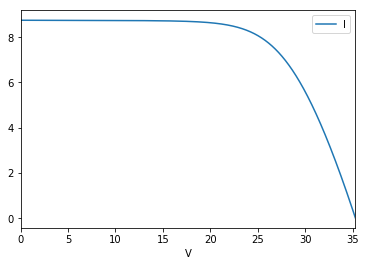

In [21]:
final.plot(x="V", y="I")

## Genetic algorithm optimisation

In [22]:
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import cma
from deap import creator
from deap import tools
import random

In [23]:
dimension = 5 # Nombre de paramètres de l'optimisation
minbounds = [1, 0.01, 50, 8, 1e-11] # Limites inférieures des paramètres
maxbounds = [2, 2, 2500, 10, 1e-7] # Limites supérieures des paramètres
nb_generation = 2 # % Nombre d'itérations
popsize = 10 # Taille de la population
p_mut = 0.1 # Probabilité de mutation

In [24]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def uniform(lower_list, upper_list, dimensions):
    """Fill array """

    if hasattr(lower_list, '__iter__'):
        return [random.uniform(lower, upper) for lower, upper in
                zip(lower_list, upper_list)]
    else:
        return [random.uniform(lower_list, upper_list)
                for _ in range(dimensions)]

toolbox = base.Toolbox()
toolbox.register("evaluate", pvopt_objfun)

In [25]:
toolbox.register("uniformparams", uniform, minbounds, maxbounds, dimension)

In [26]:
toolbox.register("Individual", tools.initIterate, creator.Individual, toolbox.uniformparams)
toolbox.register("population", tools.initRepeat, list, toolbox.Individual)

In [27]:
ETA = 10

In [28]:
# Register the mate operator
toolbox.register(
    "mate",
    tools.cxSimulatedBinaryBounded,
    eta=ETA,
    low=minbounds,
    up=maxbounds)

In [29]:
# Register the mutation operator
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA,
                 low=minbounds, up=maxbounds, indpb=0.1)

In [30]:
# Register the variate operator
toolbox.register("variate", algorithms.varAnd)

In [31]:
# Register the selector (picks parents from population)
toolbox.register(
    "select",
    tools.selNSGA2)

In [32]:
# Generate the population object
pop = toolbox.population(n=popsize)

In [33]:
# Register the statistics we want to record during the optimisation
# In this case only the minimal value
first_stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats = tools.MultiStatistics(obj1=first_stats)
stats.register("min", np.min, axis=0)

In [34]:
hof = tools.HallOfFame(5)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=nb_generation, 
                               stats=stats, halloffame=hof, verbose=True)

   	      	  obj1 
   	      	-------
gen	nevals	min    
0  	10    	31.4409
1  	9     	37.6309
2  	4     	37.6309


In [35]:
print("Initial params", params)

('Initial params', [1.411, 0.512, 1045, 9.78, 5.65e-08])


In [36]:
print("Best params", hof[0])

('Best params', [1.4869221351938875, 0.5031506139494596, 929.0007258568331, 8.519964162978562, 7.333295816533393e-08])


In [37]:
hist_best = [1.373931990553301, 0.6113338788350812, 1514.008858470765, 9.915445771346667, 4.171763773446444e-08]

In [38]:
pvopt_objfun(hof[0])

[31.440946544995192]

In [39]:
aref, Rs, Rsh, Iphref, I0ref = hof[0]

In [40]:
Iph = photo_current(Iphref, effectiveIrradiance, Gstc, Ki, Tcell, Tstc)

In [41]:
I0 = saturationCourant(I0ref, Tcell, Tstc, Eg)

In [42]:
vals = ivcurve_newton_raphson(Iph, I0, Rs, Rsh, 
                       aref, Tcell,
                       Ns, Nsh, Ns0,
                       Vmppnoct, Imppnoct)

In [43]:
final = pd.DataFrame(data={"I": vals["I"], "V": vals["V"]})

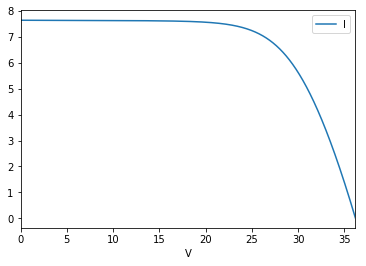

In [44]:
final.plot(x="V", y="I")